In [1]:
!pip install catboost
!pip install transformers
!pip install nltk
!pip install nlpaug
!pip install evaluate

In [2]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 39.5 MB/s eta 0:00:00
Processing /colabtools/dist/google-colab-1.0.0.tar.gz (from -r requirements.txt (line 143))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google-colab-1.0.0.tar.gz'



In [3]:
!ls

bert_multiclass1.pt	     functions_bert.py		    README.txt	      src
bert_multiclass_balanced.pt  GBC_NLP_test_news_sample.json  requirements.txt
catboost_info		     __pycache__		    sample_data


In [4]:
from src.functions_bert import dataset, f1_score_func_m, trainer, evaluate, trainer_pipeline
from src.functions_LR import count_words, text2emb_bert, dataset_pipeline

In [5]:
import json
import re
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from scipy.sparse import coo_matrix, hstack

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.nn import functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output

from transformers import (
    BertTokenizer, BertForSequenceClassification, AdamW,
    get_linear_schedule_with_warmup, DistilBertTokenizer,
    AutoModelForSequenceClassification, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification, AutoModel,
    AutoTokenizer, Trainer, TrainingArguments
)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, multilabel_confusion_matrix, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import catboost
from catboost import CatBoostClassifier, Pool
import random

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Загрузим данные

In [7]:
PATH = 'GBC_NLP_test_news_sample.json'
texts = []
labels = []

with open(PATH) as f:
    data = json.load(f)

for row in data:
    texts.append(row['content'])
    labels.append(row['classification'])

f.close()

In [8]:
df = pd.DataFrame({'text' : texts, 'label' : labels})
df.head()

,text,label
0,The Mines of Dalarnia Update 1.4: Rechained is...,"development, specified"
1,Mines of Dalarnia Mainnet—Update 1.4: Rechained,"development, specified"
2,Kava in the news [kava 14 accelerates cosmos e...,"development, specified"
3,SEC responsed: We are pleased that the court f...,sec
4,Build on Base Mainnet with 1RPC,"development, specified"


### EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    835 non-null    object
 1   label   835 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


У нас 835 объектов без пропусков

In [10]:
df['label'].value_counts()

development, specified     280
partnership, non-crypto    264
development                 66
announcement promise        59
legal, negative             39
start of burn/buyback       32
legal, positive             21
exploit                     17
raise                       16
negative                    12
selling                     12
ripple                      10
positive                     4
sec                          1
negative rebuttal            1
interested                   1
Name: label, dtype: int64

16 классов с сильным дисбалансом

##### Дубликаты

In [11]:
df[df.duplicated(subset=['text'], keep=False)==True]

,text,label
13,It is with great excitement that we announce t...,"partnership, non-crypto"
14,It is with great excitement that we announce t...,"partnership, non-crypto"
112,"MULTICHAIN FANTOM BRIDGE POSSIBLY DRAINED, AFF...",exploit
113,"MULTICHAIN FANTOM BRIDGE POSSIBLY DRAINED, AFF...",exploit
121,EMURGO Ventures Invests in Magic Square To Fur...,"partnership, non-crypto"
122,EMURGO Ventures Invests in Magic Square To Fur...,"partnership, non-crypto"
126,Multichain Team Confirms Exploit Across Fantom...,exploit
127,Multichain Team Confirms Exploit Across Fantom...,exploit
226,"Optimism, Aptos and ApeCoin set for largest to...",selling
227,"Optimism, Aptos and ApeCoin set for largest to...","development, specified"


В данных есть дубликаты.  
Несколько дубликатов принадлежат к разным классам.  
Удалим их из нашей выборки.

In [12]:
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
print(f'Кол-во дубликатов после отчистки: {df.duplicated(subset=["text"]).sum()}')
print()
df.info()

Кол-во дубликатов после отчистки: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    812 non-null    object
 1   label   812 non-null    object
dtypes: object(2)
memory usage: 12.8+ KB


Нашли и удалили 33 дубликатов

#### Распределение длин текстов

In [13]:
df['text_len'] = df.text.str.len()

<Axes: >

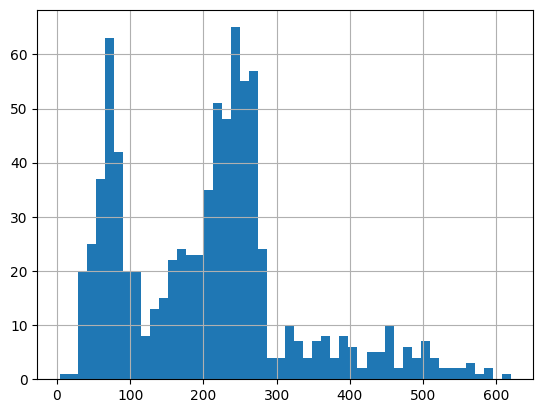

In [14]:
df['text_len'].hist(bins=50)

Распределение бимодальное с модой в 80 и 250.  
Можно сказать, что большая часть текста лежит в диапазоне 280 символов

In [15]:
df.groupby('label')['text_len'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
label,,,,
announcement promise,59,191.898305,164.0,138.749799
development,61,259.557377,255.0,157.355492
"development, specified",276,213.865942,223.5,110.722685
exploit,15,72.333333,70.0,11.962242
interested,1,228.000000,228.0,NaN
"legal, negative",32,136.937500,81.0,103.748125
"legal, positive",21,223.190476,225.0,148.468050
negative,12,86.166667,76.5,31.871427
negative rebuttal,1,160.000000,160.0,NaN


<Axes: >

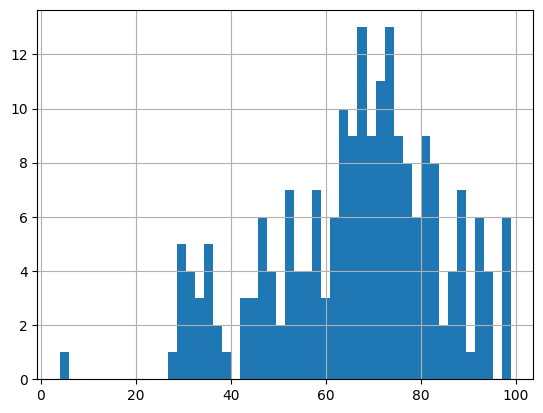

In [16]:
df.query('text_len < 100')['text_len'].hist(bins=50)

In [17]:
df.query('text_len < 100').sort_values('text_len').head()

,text,label,text_len
107,Soon,announcement promise,4
415,Synthetix lists stETH Perps,"development, specified",27
530,Flux partners with Octominer!,"partnership, non-crypto",29
545,"DeFining news: June 9th, 2023",announcement promise,29
19,Open Exchange Adds FTX Claims,positive,29


Коротких бессмысленных текстов не замечено.

#### Уберем классы с кол-вом образцов < 5

In [18]:
df['label'].value_counts()

development, specified     276
partnership, non-crypto    260
development                 61
announcement promise        59
start of burn/buyback       32
legal, negative             32
legal, positive             21
raise                       15
exploit                     15
negative                    12
selling                     12
ripple                      10
positive                     4
sec                          1
negative rebuttal            1
interested                   1
Name: label, dtype: int64

In [19]:
df['label_count'] = df.groupby('label')['label'].transform('count')
df = df.query('label_count > 5')

In [20]:
df['label'].value_counts()

development, specified     276
partnership, non-crypto    260
development                 61
announcement promise        59
start of burn/buyback       32
legal, negative             32
legal, positive             21
raise                       15
exploit                     15
negative                    12
selling                     12
ripple                      10
Name: label, dtype: int64

In [21]:
df = df.reset_index(drop=True)

#### Оценим содержимое наших таргетов

Сами по себе данные представляют собой заколовки новостные на различные таматики.  

development, specified - разработка, уточненная  
partnership, non-crypto - партнерство, не криптовалютное  
development - разработка  
announcement promise - обещание объявления  
start of burn/buyback - начало сжигания/выкупа  
legal, negative - юридически, негативно  
legal, positive - юридически, позитивно  
raise - привлечение (финансирования)  
exploit - эксплуатировать  
negative - негативный  
selling - продажа  
ripple - криптовалюта Ripple  

Тут сразу видно несколько проблем:
ripple - криптовалюта Ripple  
1. Есть категории как по содержанию заголовка (selling, development, ...), так по эмоциональному содержанию текста (negative).  
При этом одна тема по содержанию разбита на темы по эмоциональности (legal negative, legal positive).
2. Две большие группы development и development specified вообщем относятся к одной группе по содержанию, но различаются глубиной контекста.  

Проблемы:   
Все это в купе с дисбалансом и маленькой выборкой создаст  определенныне сложности при обучении хорошего классификаторв.

Гипотезы:  
1. Обучить несколько моделей на определение разных составляющих.  
Допустим обучить модель для предсказания любого legit и уже потом делить их на positive и negative.  
2. Обучить одну большую сложную модель, которая бы могла разделить классы.  
На ум приходит какой-нибудь BERT, его даже не обязательно обучать полностью, можно дообучить только "голову"

In [22]:
for t in df['label'].unique():
    print(f"label: {t}")
    for idx in range(6):
        print(f'''{idx}: {df.query(f'label =="{t}"')['text'].iloc[idx]}''')

    print('____')

label: development, specified
0: The Mines of Dalarnia Update 1.4: Rechained is now LIVE! This new version reintroduces all of the previous blockchain features along with new ones on BSC Mainnet, including: 1⃣ Off-chain and on-chain crafting. 2⃣ New competition mode. 3⃣ Spacehop. 4⃣ New monster, and…
1: Mines of Dalarnia Mainnet—Update 1.4: Rechained
2: Kava in the news [kava 14 accelerates cosmos ecosystem expansion]
3: Build on Base Mainnet with 1RPC
4: No better time than to @buildonbase with Base Mainnet now open to builders - devs, access the network with our dedicated 1RPC endpoint and start building the on-chain future today We can't wait to see what you'll get up to:
5: Dive deep into 14! Introducing the 'internal bridge', a secure module enabling seamless interoperability between Cosmos & Ethereum ecosystems. Effortlessly convert tokens into ERC20 for use in the environment
____
label: partnership, non-crypto
0: SimWin Sports and Immutable: Bringing Digital Ownership to Fantas

Также в тексте очень много симоволов, абривиатур, чисел, ссылок.  
Очевидно, некоторые из таких обозначений могу помогать модели определять класс заголовка, но в тоже время избыточно наращивать размеры словаря и создавать вредный шум.

### Подготовка данных

#### Токенизируем целевую переменную

Отсортируем их по кол-ву (для воспроизводимости) и создадим словарь метки класс : токен

In [23]:
lable2token = {token: idx for idx, token in enumerate(df['label'].value_counts().index)}
print(lable2token)

{'development, specified': 0, 'partnership, non-crypto': 1, 'development': 2, 'announcement promise': 3, 'start of burn/buyback': 4, 'legal, negative': 5, 'legal, positive': 6, 'raise': 7, 'exploit': 8, 'negative': 9, 'selling': 10, 'ripple': 11}


In [24]:
df['labels_token'] = df['label'].replace(lable2token)

<Axes: >

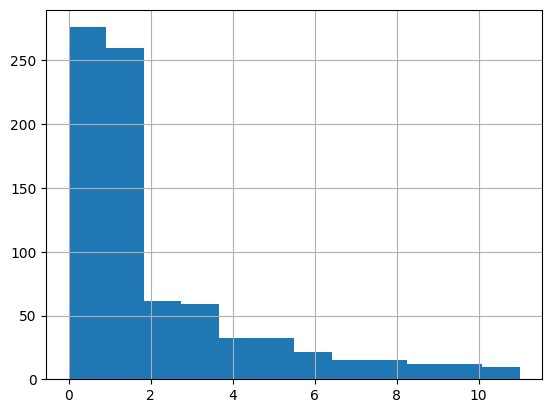

In [25]:
df['labels_token'].hist(bins=12)

#### Отчистим и подготовим данные

Напишем несколько функций для разного типа отчистки данных.  
Сохраним отчищенный текст в новой переменной.

In [26]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_special_chars(x):
    x = re.sub(r'[^a-zA-Z0-9@;:\s]', '', x)
    x = ' '.join(x.split())
    return x

def remove_control_characters(x):
    pattern = re.compile(r'[\n\t\r\\\'\"]')
    return re.sub(pattern, '', x)

def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def remove_stopwords(x, stop_words=stop_words):
    return ' '.join([t for t in x.split() if t not in stop_words])

def remove_bch_adress(x):
    return re.sub(r'0x[0-9a-zA-Z]+', '', x).strip()

def remove_words_starting_with_at(x):
    return re.sub(r'@\w+\s*', '', x)

def lemmatize_text(x, lemmatizer=lemmatizer):
    return ' '.join([lemmatizer.lemmatize(w) for w in x.split()])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
col_name = 'text_clean'
df[col_name] = df['text'].apply(lambda x: remove_emails(x)) # убрать адреса email
df[col_name] = df[col_name].apply(lambda x: remove_urls(x)) # убрать urls
df[col_name] = df[col_name].apply(lambda x: remove_bch_adress(x)) # убрать адреса биткойн кошелька
df[col_name] = df[col_name].apply(lambda x: remove_control_characters(x)) # убрать симолы контроля строки
df[col_name] = df[col_name].apply(lambda x: remove_words_starting_with_at(x)) # убрать ссылки на акаунты начинающиеся с @
df[col_name] = df[col_name].apply(lambda x: remove_special_chars(x)) # убрать убрать все специальные символы кроме букв и цифр
df[col_name] = df[col_name].apply(lambda x: remove_stopwords(x)) # убрать все стоп слова
df[col_name] = df[col_name].apply(lambda x: lemmatize_text(x)) # убрать лематезировать текст
df[col_name] = df[col_name].apply(lambda x: x.lower()) # привести к нижнему регистру

In [28]:
df['text_clean'][0]

'the mines dalarnia update 14: rechained live this new version reintroduces previous blockchain feature along new one bsc mainnet including: 1 offchain onchain crafting 2 new competition mode 3 spacehop 4 new monster'

#### Посмотрим самые частые слова после преобразований и до

In [29]:
count_vectorizer = CountVectorizer()

In [30]:
count_words(df['text_clean']) # отчищенный текст

the            143
tweet          132
new            113
announce       100
we              98
partnership     91
web3            88
mainnet         79
ecosystem       74
launch          74
network         73
were            73
token           67
blockchain      62
news            61
user            60
join            56
thrilled        56
platform        56
first           54
protocol        53
live            53
support         53
this            52
june            50
partner         50
learn           50
exciting        49
coming          49
excited         48
dtype: int64

In [31]:
count_words(df['text']) # исходный текст

the         1167
to           948
and          566
of           481
on           441
with         385
for          367
is           306
in           298
we           295
from         216
our          180
more         147
are          133
this         133
tweet        132
now          131
quoting      131
will         129
that         119
be           119
as           117
you          114
new          114
tier10k      112
re           104
has          103
it           102
announce     100
by            98
dtype: int64

Видно, что в исходном тексте было несколько очень частотных слов таких как the, to,and, ....   
Их удаление не всегда сильно влияет на результат, а для трансформеров лучше вообщем использовать исходные данные.  
Попробуем несколько вариантов в дальнейшем.

### Разделим данные на train, val и test

Разделим данные на 3 группы: обучающая, валидационная и тестовая.  
На обучающей и валидационной выберем модель или модели.  
На тестовой протестируем полученное решение.  

Т.к. данных мало и классы сильно не сбалансированны, то будем использовать стратификацию.

In [32]:
train_val, test, target_train_val, target_test = train_test_split(df['text'],
                                                                  df['labels_token'].values,
                                                                  test_size=0.15,
                                                                  stratify=df['labels_token'],
                                                                  random_state=42)

In [33]:
train, val, target_train, target_val = train_test_split(train_val,
                                                        target_train_val,
                                                        test_size=0.2,
                                                        stratify=target_train_val,
                                                        random_state=42)

Также разобъем очищенную выборку

In [34]:
train_val_clean, test_clean, target_train_val_clean, target_test_clean = train_test_split(df['text_clean'],
                                                                                          df['labels_token'].values,
                                                                                          test_size=0.15,
                                                                                          stratify=df['labels_token'],
                                                                                          random_state=42)

In [35]:
train_clean, val_clean, target_train_clean, target_val_clean = train_test_split(train_val_clean,
                                                                                target_train_val_clean,
                                                                                test_size=0.2,
                                                                                stratify=target_train_val_clean,
                                                                                random_state=42)

In [36]:
print(f'train: {train.shape}')
print(f'val: {val.shape}')
print(f'test: {test.shape}')

train: (547,)
val: (137,)
test: (121,)


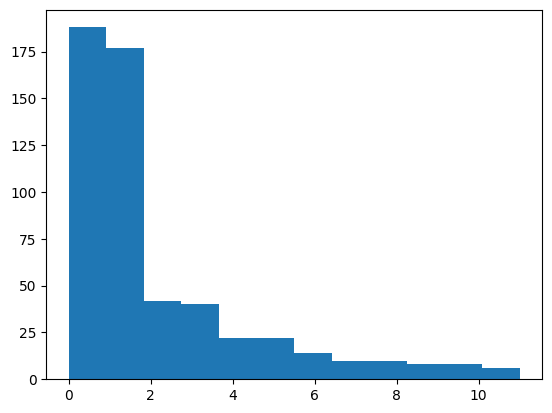

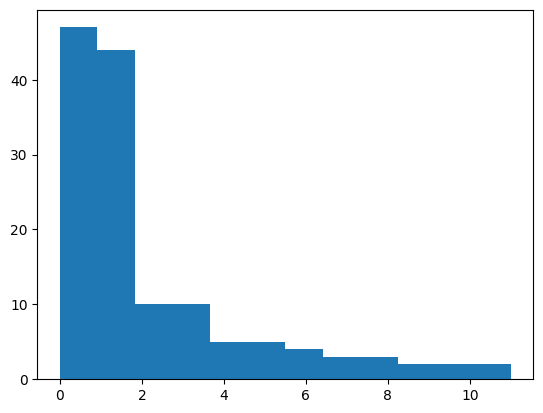

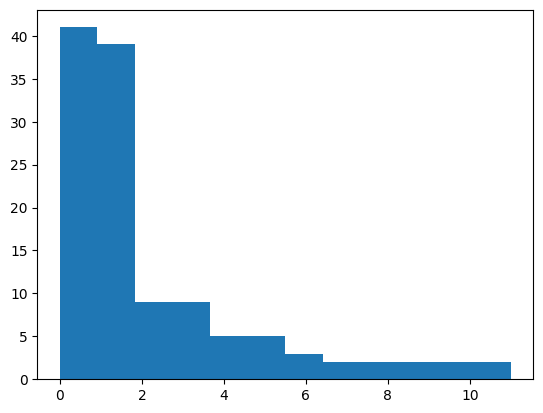

In [37]:
plt.hist(target_train, bins=12)
plt.show()
plt.hist(target_val, bins=12)
plt.show()
plt.hist(target_test, bins=12)
plt.show()

данные разделены пропорционально по каждому классу, распределение классов не изменилось.

### Выбор модели

При дальнейшем выборе моделей будем следовать такому плану.
Извлечем признаки из текста двумя способами.  
1. Применим TFIDF
2. Применим предобученный BERT и возьмем эмебединг предложения на последнем слое
3. Сожмем в PCA
4. Передадим в LogReg или Catboost

Оцениваем качество моделей будем оценивать используя f1-macro.  
Эта метрика равноценно учитывает классы, поэтому ошибки в минорных классах будут "стоить дорого".

In [38]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

В качестве модели для токенизации возьмем ProsusAI/finbert, обученную на определение тональности экономических новостей.  
https://huggingface.co/ProsusAI/finbert  

Идея в том, что TFIDF должен дать нам понимание о составе текста, а BERT добавит информацию о тональности.

In [39]:
HF = 'ProsusAI/finbert'

tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)

model = AutoModel.from_pretrained(HF)
model.to(device)

scaler = StandardScaler()

pca = PCA()

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=30000, ngram_range=(1, 4))

scores = []

cv_stratified = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

logit = LogisticRegression(class_weight='balanced',
                           max_iter=150,
                           C=1,
                           solver='lbfgs',
                           multi_class='multinomial',
                           random_state=42,
                           n_jobs=4)

Т.к. данные имеют сильный дисбаланс и при этом выборка небольшая, то возьмем 7 сплитов данных, чтобы лучше оценить качество.

### На исходных (неочищенных) данных

Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке с TF-IDF и без BERT.

In [40]:
model_wo_bert = []
scores_wo_bert = []

for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val = dataset_pipeline(train_val.values,
                                            target_train_val,
                                            tokenizer_bert=tokenizer,
                                            model_bert=model,
                                            pca=pca,
                                            tfidf=vectorizer,
                                            scaler=scaler,
                                            index_train=index_train,
                                            index_val=index_val,
                                            device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    scores_wo_bert.append(score)
    model_wo_bert.append(logit)

print(f'mean_score: {np.mean(scores_wo_bert)}')
print(f'mean_score: {np.std(scores_wo_bert)}')


mean_score: 0.4384038078019433
mean_score: 0.06365920061454444


In [41]:
парапрпао

NameError: ignored

Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и **с BERT**.

In [ ]:
model_w_bert = []
scores_w_bert = []

for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val = dataset_pipeline(train_val.values,
                                                      target_train_val,
                                                      tokenizer_bert = tokenizer,
                                                      model_bert = model,
                                                      pca = pca,
                                                      tfidf = vectorizer,
                                                      scaler=scaler,
                                                      index_train=index_train,
                                                      index_val=index_val,
                                                      bert=True,
                                                      device=device)

    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    scores_w_bert.append(score)
    model_w_bert.append(logit)

print(f'mean_score: {np.mean(scores_w_bert)}')
print(f'std_score: {np.std(scores_w_bert)}')



### На очищенных данных

Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и без **BERT**.

In [ ]:
model_wo_bert_clean = []
scores_wo_bert_clean = []

for index_train, index_val in cv_stratified.split(train_val_clean, target_train_val_clean):
    X_train, X_val, y_train, y_val = dataset_pipeline(train_val_clean.values,
                                            target_train_val_clean,
                                            tokenizer_bert=tokenizer,
                                            model_bert=model,
                                            pca=pca,
                                            tfidf=vectorizer,
                                            scaler=scaler,
                                            index_train=index_train,
                                            index_val=index_val,
                                            device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    scores_wo_bert_clean.append(score)
    model_wo_bert_clean.append(logit)

print(f'mean_score: {np.mean(scores_wo_bert_clean)}')
print(f'mean_score: {np.std(scores_wo_bert_clean)}')


Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и **с BERT**.

In [ ]:
model_w_bert_clean = []
scores_w_bert_clean = []

for index_train, index_val in cv_stratified.split(train_val_clean, target_train_val_clean):

    X_train, X_val, y_train, y_val = dataset_pipeline(train_val_clean.values,
                                                      target_train_val_clean,
                                                      tokenizer_bert=tokenizer,
                                                      model_bert=model,
                                                      pca=pca,
                                                      tfidf=vectorizer,
                                                      scaler=scaler,
                                                      index_train=index_train,
                                                      index_val=index_val,
                                                      bert=True,
                                                      device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    scores_w_bert_clean.append(score)
    model_w_bert_clean.append(logit)

print(f'mean_score: {np.mean(scores_w_bert_clean)}')
print(f'mean_score: {np.std(scores_w_bert_clean)}')

Как видим, модели обученные на очищенных данных показывают хуже результаты, чем "сырые".

В дальнейшем будем использовать модели обученные на сырых данных.



Оценим качество модели логистической регрессии на **обучающей и валидационной** выборке **с TF-IDF** и **без BERT**.

mean_score: 0.40768121545432473
              precision    recall  f1-score   support

           0       0.64      0.83      0.72        47
           1       0.70      0.86      0.78        44
           2       0.67      0.20      0.31        10
           3       0.57      0.40      0.47        10
           4       1.00      0.80      0.89         5
           5       0.67      0.80      0.73         5
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.68       137
   macro avg       0.44      0.41      0.41       137
weighted avg       0.61      0.68      0.63       137



<Axes: >

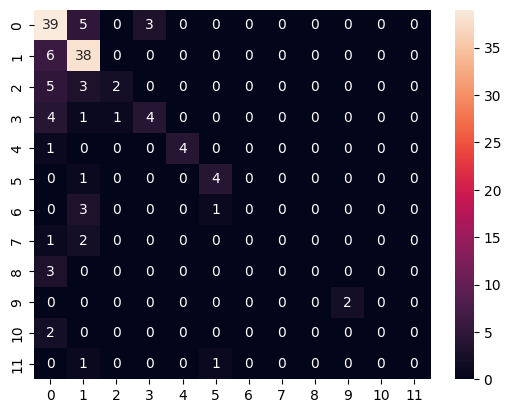

In [69]:
scores_full = []
model_full = []
pred_prob_full = []

X_train, X_val, y_train, y_val = dataset_pipeline((train, val),
                                        (target_train, target_val),
                                        tokenizer_bert = tokenizer,
                                        model_bert = model,
                                        pca = pca,
                                        tfidf = vectorizer,
                                        scaler=scaler,
                                        index_train = index_train,
                                        index_val = index_val,
                                        bert=False,
                                        cv=False)

logit.fit(X_train, y_train)
y_pred = logit.predict(X_val)
y_pred_prob = logit.predict_proba(X_val)
score = f1_score(y_val, y_pred, average='macro')

scores_full.append(score)
model_full.append(logit)
pred_prob_full.append(y_pred_prob)

print(f'mean_score: {np.mean(scores_full)}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


Оценим качество модели логистической регрессии на **обучающей и валидационной** выборки **с TF-IDF** и **с BERT**.

In [ ]:
scores_full_w_bert = []
model_full_w_bert = []
pred_prob_full_w_bert = []
pca_full_w_bert = []

X_train, X_val, y_train, y_val = dataset_pipeline((train, val),
                                        (target_train, target_val),
                                        tokenizer_bert = tokenizer,
                                        model_bert = model,
                                        pca = pca,
                                        tfidf = vectorizer,
                                        scaler=scaler,
                                        index_train = index_train,
                                        index_val = index_val,
                                        bert=True,
                                        cv=False,
                                        device=device)

logit.fit(X_train, y_train)
y_pred = logit.predict(X_val)
y_pred_prob = logit.predict_proba(X_val)
score = f1_score(y_val, y_pred, average='macro')

scores_full_w_bert.append(score)
model_full_w_bert.append(logit)
pred_prob_full_w_bert.append(y_pred_prob)
pca_full_w_bert.append(pca)

print(f'mean_score: {np.mean(scores_full_w_bert)}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


### Выводы

На сырых данных модель показала лучше результат, чем на обработанных.   


Судя по матрице ошибок, линейная модель хорошо определяет классы с большими числом объектов, хуже классы с маленьким числом объектов.

При этом из-за использования **f1-macro** в качестве целевой метрики получаем сильный штраф за ошибки в минорных классах, в то время как ошибки в мажорных классах менее критичны.


Кросс-валидация показывает, что модель у которой датасет включается в себя как TF-IDF, так и BERT эмбединги, имею средний скор выше моделей обученых только на TFIDF, причем отклонение оценок ниже у первой.  

Можно сделать вывод, что TFIDF+BERT_EMB дает прирости в качестве.
При это модели обученные на всей обучающей выборке имеют схожие резльтаты качества.  
Эти модели сохраним, они пригодятся далее.

TO DO  
Можно покомбинировать типы предобработки данных, возможно получится найти оптимально сочитание, что поможет увеличить метрику.   
Попробовать на  аугументированном датасете.

### CatBoost

LogReg показала хороший результат на TF-IDF + EMB.  

Гипотеза:
- Бустингом можно выжать больше пользы из данных, найти новые зависимости.  

Проблемы:
- Бустинги не всегда хорошо работают, если есть сильная линейная связь
- В бустинги надо аккуратно настраивать гиперпараметры

Решение:
- Возьмем CatBoost, он "из коробки" показывает хорошие результаты, если будет похоже на лучший результат, чем LogReg, то можно подобрать гиперпараметры, если нет, то нет.

In [ ]:
cb = CatBoostClassifier(task_type="GPU",
                        auto_class_weights='Balanced',
                        loss_function='MultiClass',
                        verbose=True)

Оценим качество модели Catboost на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и **с BERT**.

In [ ]:
cb_model_w_bert = []
cb_scores_w_bert = []
for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val = dataset_pipeline(train_val.values,
                                                      target_train_val,
                                                      tokenizer_bert=tokenizer,
                                                      model_bert=model,
                                                      pca=pca,
                                                      tfidf=vectorizer,
                                                      scaler=scaler,
                                                      index_train=index_train,
                                                      index_val=index_val,
                                                      bert=True,
                                                      cv=True,
                                                      device=device)

    text_pool = Pool(data=X_train, label=y_train)
    eval_pool = Pool(data=X_val, label=y_val)

    cb.fit(text_pool, eval_set=eval_pool, verbose=False)
    y_pred = cb.predict(eval_pool)
    score = f1_score(y_val, y_pred, average='macro')

    cb_scores_w_bert.append(score)
    cb_model_w_bert.append(cb)

print(np.mean(cb_scores_w_bert))
print(np.std(cb_scores_w_bert))


In [ ]:
cb_scores_w_bert

Оценим качество модели Catboost на **обучающей и валидационной** выборки **с TF-IDF** и **с BERT**.

In [ ]:
cb_scores_full = []
cb_model_full = []

X_train, X_val, y_train, y_val = dataset_pipeline((train, val),
                                                  (target_train, target_val),
                                                  tokenizer_bert = tokenizer,
                                                  model_bert = model,
                                                  pca = pca,
                                                  tfidf = vectorizer,
                                                  scaler=scaler,
                                                  index_train = index_train,
                                                  index_val = index_val,
                                                  bert=True,
                                                  cv=False,
                                                  device=device)

text_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_val, label=y_val)

cb.fit(text_pool, eval_set=eval_pool, verbose=False)
y_pred = cb.predict(eval_pool)
score = f1_score(y_val, y_pred, average='macro')

cb_scores_full.append(score)
cb_model_full.append(cb)

print(np.mean(cb_scores_full))
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)

In [ ]:
cb_scores_full

В целом CatBoost сопостовимые результаты с логистической регрессией, не превзошел.  

TO DO  
Попробовать другие бустинги, настроить гиперапараметры

Остановим свой выбора на LogReg на сырых данных с BERT

### BERT

Т.к. датасет маленький, классов много, дисбаланс большой, то можно предположить следующие гипотезы, в которых BERT может быть полезен:  
1. В качестве признаков для модели (реализовано ранее с линейной регрессией, показало эффективность)
2. Самостоятельная модель, которую можно дообучить на данных и получить одну модель способную эффективно определять классы.  
Тут проблем несколько:
- Модель требует все-таки большую выборку для дообучения, чтобы показать значитенльный результат. На мальенком кол-ве данных сложные зависимости она просто не сможет достать.
- Модель скорее настроена на определения "смысла" текста, нежели на схожесть по словам. А судя по датасету и результатам TF-IDF, да и в целом задачи классификации текстов, частотность слов является хорошим предиктором для большинства задачи.  
3. Что успел попробовать?  
- Попытки обучить самостоятельную модель не показали результатов превышающих LogReg.  Пробовал разные предобученные модели, надстраивал "головы", дообучал блоки внимания, потратил много часов GPU в Colab, но лучше LogReg не получилось сделать.  

**Решение**  
Попробовать объединить результаты LogReg обученной на TFIDF и BERT, используя взвешенную сумму уверенносте (вероятностей) моделей.  
Смысл в том, что TF-IDF ориентируется на конструкцию текста, а BERT на "смысла" текста.   

In [42]:
from transformers import BertTokenizer
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from tqdm.notebook import tqdm
from IPython.display import clear_output
from transformers import DistilBertTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AutoModel, AutoTokenizer,Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import functional as F
from transformers import get_linear_schedule_with_warmup

In [43]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

Предобученная модель BERT

In [44]:
HF = 'ProsusAI/finbert'

Подготовим данные   

Т.к. CV на таких моделях проводить слишком трудозатратно и не особо эффективно, то дообучим модель на train и val.

In [56]:
tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)
train_dataloader, val_dataloader, test_dataloader = dataset(train, val, test, tokenizer, target_train, target_val, target_test, batch_size=50)

In [57]:
# сбор и отчистка мусора перед обучением
import gc
gc.collect()
torch.cuda.empty_cache()


Training loss: 1.244
Validation loss: 1.672
0.2888717172692832


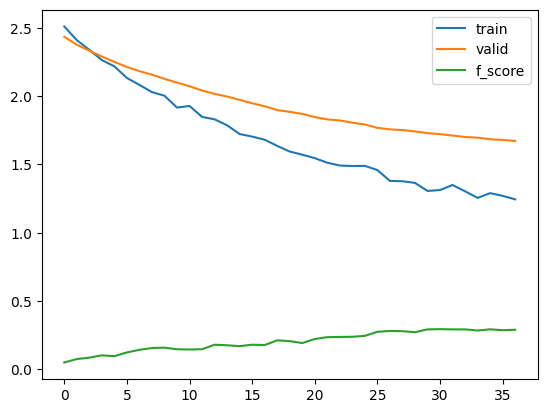


 Epoch38 / 100


  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [59]:
PATH_MODEL='bert_multiclass1.pt'
epochs = 50

model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=3, num_training_steps=total_steps)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target_train_val), y=target_train_val)
class_weights = (class_weights / class_weights.sum())
class_weights = torch.tensor(class_weights).float().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

_, _, _ = trainer_pipeline(epochs=epochs,
                PATH_MODEL=PATH_MODEL,
                model = model,
                HF = HF,
                optimizer = optimizer,
                scheduler = scheduler,
                criterion = criterion,
                train_dataloader = train_dataloader,
                val_dataloader = val_dataloader,
                device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.13      0.21        47
           1       0.65      0.64      0.64        44
           2       0.25      0.60      0.35        10
           3       0.28      0.70      0.40        10
           4       0.71      1.00      0.83         5
           5       0.30      0.60      0.40         5
           6       0.20      0.25      0.22         4
           7       0.29      0.67      0.40         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.42       137
   macro avg       0.28      0.38      0.29       137
weighted avg       0.53      0.42      0.40       137



<Axes: >

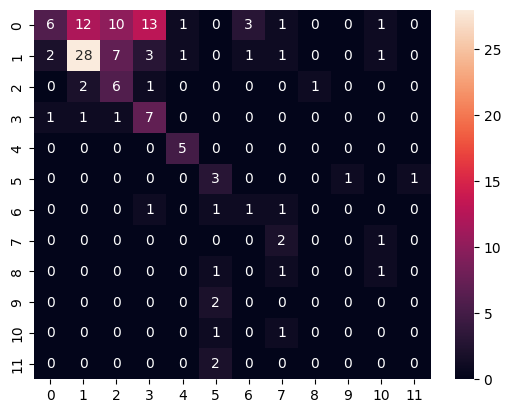

In [60]:
model.load_state_dict(torch.load(PATH_MODEL, map_location=device))
valid_loss, valid_pred, valid_labels = evaluate(model, criterion, val_dataloader, device=device)

print(classification_report(valid_labels, np.argmax(valid_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(valid_labels, np.argmax(valid_pred, axis=1).flatten()), annot=True)

Удивительный факт, эта модель показывает лучший скор на меньшем размере батча, причем  различие значительное.

#### BERT + TEXT GEN

Посмотрим на результаты модели при сбалансированной выборке при помощи аугументации.   
Будет заменять слова на синонимы.

In [61]:
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug(aug_src='wordnet')
unique, counts = np.unique(target_train, return_counts=True)
add_train = train.to_list()
add_target_train = list(target_train)

max_count = max(counts)

for idx, n in enumerate(unique):
  features_num = max_count - counts[idx]
  examples = np.random.choice(np.array(train.to_list())[target_train == n], features_num, replace=True)

  for sentance in examples:
    add_train.extend(aug.augment(sentance))
  add_target_train.extend([n]*features_num)

In [62]:
len(add_train)

2256

In [63]:
len(add_target_train)

2256

In [64]:
train_dataloader, val_dataloader, test_dataloader = dataset(add_train, val, test, tokenizer, add_target_train, target_val, target_test, batch_size=150)


Training loss: 0.382
Validation loss: 0.997
0.46875386858863394


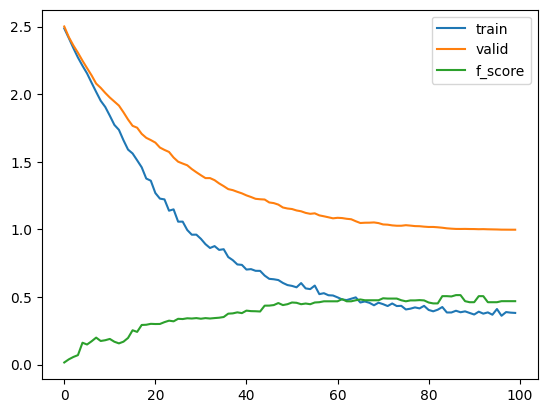

In [65]:
PATH_MODEL='bert_multiclass_balanced.pt'
epochs = 100

model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)

optimizer = AdamW(model.parameters(), lr=1e-5)

total_steps = len(train_dataloader) * epochs
optimizer = AdamW(model.parameters(), lr=1e-5)

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=3, num_training_steps=total_steps)

criterion = nn.CrossEntropyLoss()

_, _, _ = trainer_pipeline(epochs=epochs,
                          PATH_MODEL=PATH_MODEL,
                          model = model,
                          HF = HF,
                          optimizer = optimizer,
                          scheduler = scheduler,
                          criterion = criterion,
                          train_dataloader = train_dataloader,
                          val_dataloader = val_dataloader,
                          device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        47
           1       0.73      0.75      0.74        44
           2       0.71      0.50      0.59        10
           3       0.73      0.80      0.76        10
           4       0.71      1.00      0.83         5
           5       0.40      0.80      0.53         5
           6       0.40      0.50      0.44         4
           7       0.17      0.33      0.22         3
           8       0.33      0.33      0.33         3
           9       0.00      0.00      0.00         2
          10       0.50      0.50      0.50         2
          11       0.00      0.00      0.00         2

    accuracy                           0.65       137
   macro avg       0.45      0.51      0.47       137
weighted avg       0.66      0.65      0.65       137



<Axes: >

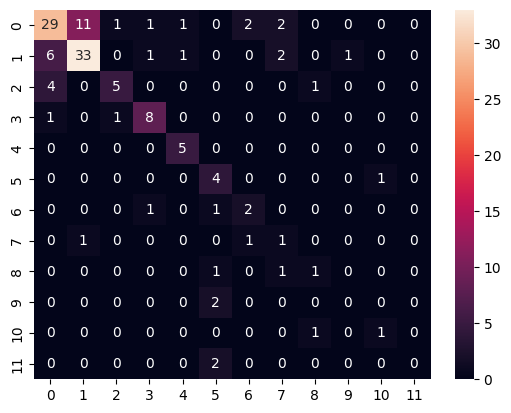

In [66]:
model.load_state_dict(torch.load(PATH_MODEL, map_location=device))
add_valid_loss, add_valid_pred, add_valid_labels = evaluate(model, criterion, val_dataloader, device=device)

print(classification_report(add_valid_labels, np.argmax(add_valid_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(add_valid_labels, np.argmax(add_valid_pred, axis=1).flatten()), annot=True)

### Blending

Подберем коэффициент для смешивания предсказания моделей.  
Для этого возьмем предсказания LogReg модели обученной только на TDIDF и BERT и подберем коэф, при котороом их сумма максимальная.  
( скорее всего это не самый объектиыный способ подбора, можно попробовать кросс-валидации и тп.)

In [67]:
bert_pred = F.softmax(torch.tensor(valid_pred)).detach().cpu().numpy()

<ipython-input-67-0cbbfb82028d>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  bert_pred = F.softmax(torch.tensor(valid_pred)).detach().cpu().numpy()


In [68]:
lr_pred = pred_prob_full

NameError: ignored

Найдем оптимальный порог "trsh"

In [ ]:
res_score = {}

for i in range(0, 100, 1):
  i = i / 100
  y_pred_blend = np.argmax(bert_pred * (1 - i) + lr_pred * i, axis=1)
  score = f1_score(target_val, y_pred_blend, average='macro')
  res_score[i] = score

for key, value in res_score.items():
  if value == max(res_score.values()):
    trsh = key

Смешаем и предскажем

In [ ]:
y_pred_blend = np.argmax(bert_pred*(1 - trsh) + lr_pred*trsh, axis=1)

In [ ]:
y_pred_blend

In [ ]:
print(classification_report(target_val, y_pred_blend, zero_division=0))
sns.heatmap(confusion_matrix(target_val, y_pred_blend), annot=True)

### Test

Выше мы сделали два основных вывода:  
1. LogReg с TFIDF + BERT_EMB показала лучшее качество, чем c TFIDF.  
2. Смешивание результатов прогноза LogReg на TFIDF и BERT дообученного на train дает маленький, но прирост в метрике.  

Проверим обе модели на отложенной выборке test

**LogReg**

In [ ]:
X_train, X_val, y_train, y_val = dataset(val,
                                        target_val,
                                        tokenizer_bert = tokenizer,
                                        model_bert = model,
                                        pca = PCA(n_components=500),
                                        tfidf = vectorizer,
                                        scaler=scaler,
                                        index_train = index_train,
                                        index_val = index_val,
                                        bert=True,
                                        cv=False,
                                        is_test=True)

logit = model_full_w_bert[0]
y_pred = logit.predict(X_val)
score = f1_score(y_val, y_pred, average='macro')

print(f'score: {score}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


In [ ]:
y_pred_proba.shape

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)

# Загрузка весов в модель
model.load_state_dict(torch.load(PATH_MODEL, map_location=device))
model.to(device)
# Убедитесь, что модель находится в режиме оценки
model.eval()

In [ ]:
test_loss, test_pred, test_labels = evaluate(model, criterion, test_dataloader)

print(classification_report(test_labels, np.argmax(test_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(test_labels, np.argmax(test_pred, axis=1).flatten()), annot=True)

In [ ]:
logist_softmax = F.softmax(torch.tensor(test_pred)).detach().cpu().numpy()

In [ ]:
test_pred_concat = np.argmax(logist_softmax*(1 - trsh) + y_pred_proba*trsh, axis=1)

In [ ]:
print(classification_report(test_labels, test_pred_concat, zero_division=0))
sns.heatmap(confusion_matrix(test_labels, test_pred_concat), annot=True)

In [ ]:
vbngjhgjghjjhg

### Inference

In [ ]:
X_train, X_val, y_train, y_val = dataset_pipeline(val,
                                                target_val,
                                                tokenizer_bert = tokenizer,
                                                model_bert = model,
                                                pca = PCA(n_components=547),
                                                tfidf = vectorizer,
                                                scaler=scaler,
                                                index_train = index_train,
                                                index_val = index_val,
                                                bert=False,
                                                cv=False,
                                                is_test=True,
                                                inference=True)

logit = model_full[0]
y_pred = logit.predict(X_val)
y_pred_proba = logit.predict_proba(X_val)
score = f1_score(y_val, y_pred, average='macro')

print(f'score: {score}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


## Обучение моделей

## TF_IDF

### RandomClassifier

In [ ]:
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

Модель выбирающая классы случайно показывает качество F1=0.08.  
Возьмем это за ориентир худшего случая работы модели.

### Logistic Regression

Создадим логистическую регрессию.   
Проведем кросс-валидацию и затем обучим модель и посмотрим результаты работы модели.

##### **Binary 0 or 2 and others**

In [ ]:
y_train3 = np.array([1 if i==6 or i==7 else 0 for i in y_train])
y_test3 = np.array([1 if i==6 or i==7 else 0 for i in y_test])


In [ ]:
#logit3 = LogisticRegression(class_weight='balanced', max_iter=150, C=1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=4)
logit3 = LogisticRegression(class_weight='balanced', max_iter=150, C=1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=4)

In [ ]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv_results = cross_val_score(logit3, X_train, y_train3, cv=skf, scoring='f1_macro');

In [ ]:
cv_results, cv_results.mean()

In [ ]:
logit3.fit(X_train, y_train3)
y_pred3 = logit3.predict(X_test)

In [ ]:
print(classification_report(y_test3, y_pred3, zero_division=0))

##### **Split 0 and 2**

In [ ]:
y_trainR = np.array([6 if i==6 else i for i in y_train])
y_testR = np.array([6 if i==6 else i for i in y_test])


In [ ]:
y_trainR.shape

In [ ]:
y_testR.shape

In [ ]:
logitR = LogisticRegression(class_weight='balanced', max_iter=150, C=1, solver='saga', multi_class='multinomial', random_state=42, n_jobs=4)

In [ ]:
logitR

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = cross_val_score(logitR, X_train, y_trainR, cv=skf, scoring='f1_macro');

In [ ]:
cv_results, cv_results.mean()

In [ ]:
logitR.fit(X_train, y_trainR)
y_predR = logitR.predict(X_test)

In [ ]:
y_predR.shape

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
t = list(lable2tokenR.keys())
t

In [ ]:
print(classification_report(y_testR, y_predR, zero_division=0))

In [ ]:
sns.heatmap(confusion_matrix(y_testR, y_predR), annot=True)

##### **Full model**

In [ ]:
logitR.fit(X_train, y_train)
y_pred = logitR.predict(X_test)


In [ ]:
logitR.coef_

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

В целом, видим ожидаемый резултат.  
Модель стабильно хорошо предсказывает классы, где много представителей (3,8).  
Остальные классы с малым кол-вом объектов предсказания сильно не стабильный.  
Какие-то классы предсказывает точно практически полностью(8), некоторые вообще не распознала(4).

### CatBoost

In [ ]:
grid = {
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.07, 0.09, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3,  0.5],
    'depth': [2, 3, 4, 5, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9], 'n_estimators': [100, 500, 1000, 1300], 'random_seed': [42]
}

In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool

# Создание Pool (для удобства работы с текстовыми данными)
text_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_test, label=y_test)
# Создание модели CatBoostClassifier
model = CatBoostClassifier(iterations=1000,
                           depth=2,
                           task_type="GPU",
                           auto_class_weights='Balanced',
                           learning_rate=0.2,
                           loss_function='MultiClass',
                           l2_leaf_reg = 4,
                           verbose=True)

model.fit(text_pool, eval_set=eval_pool, verbose=100)

y_pred = model.predict(eval_pool)




In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool

# Создание Pool (для удобства работы с текстовыми данными)
text_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_test, label=y_test)
# Создание модели CatBoostClassifier
model = CatBoostClassifier(iterations=1000,
                           depth=2,
                           task_type="GPU",
                           auto_class_weights='Balanced',
                           learning_rate=0.2,
                           loss_function='MultiClass',
                           l2_leaf_reg = 4,
                           verbose=True)

model.randomized_search(grid,     X=text_pool,    partition_random_seed=42,       stratified=True)




In [ ]:
# Обучение модели
model.fit(text_pool, eval_set=eval_pool, verbose=100)

y_pred = model.predict(eval_pool)

In [ ]:
print(model.get_all_params())

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

In [ ]:
y_testR

In [ ]:
y_pred

In [ ]:
lable2tokenR

In [ ]:
sns.heatmap(confusion_matrix(y_testR, y_pred), annot=True)

In [ ]:
gfhgfjhgjhgjghj

## BERT

In [ ]:
trainR = np.array(train.to_list())[y_train3==1]
y_trainR = y_train[y_train3==1]
testR = np.array(test.to_list())[y_test3==1]
y_testR = y_test[y_test3==1]

In [ ]:
y_testR[y_testR == 2] = 1
y_testR[y_testR != 1] = 0

In [ ]:
y_trainR[y_trainR == 2] = 1
y_trainR[y_trainR != 1] = 0

In [ ]:
unique, counts = np.unique(y_testR, return_counts=True)

dict(zip(unique, counts))

In [ ]:
unique, counts = np.unique(y_trainR, return_counts=True)

dict(zip(unique, counts))

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func_m(preds, labels, average = 'binary'):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #print(preds[0], preds_flat, labels_flat)
    return f1_score(labels_flat, preds_flat, average=average)

def f1_score_func(preds, labels,trsh):
    return f1_score(labels, (np.array(preds)>trsh)*1)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

aug = naw.SynonymAug(aug_src='wordnet')
unique, counts = np.unique(y_trainR, return_counts=True)
add_train_2 = []
add_train_2_y = np.ones(counts[0] - counts[1], dtype=int)

for i in np.random.choice(np.array(train.to_list())[y_trainR == 1], counts[0] - counts[1], replace=True):
  add_train_2.append(*aug.augment(i))


In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')
unique, counts = np.unique(y_trainR, return_counts=True)
add_train_2 = []
add_train_2_y = np.ones(counts[0] - counts[1], dtype=int)

for i in np.random.choice(np.array(train.to_list())[y_trainR == 1], counts[0] - counts[1], replace=True):
  add_train_2.append(*aug.augment(i))


In [ ]:
unique, counts = np.unique(y_trainR, return_counts=True)

dict(zip(unique, counts))

In [ ]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
#aug = naw.ContextualWordEmbsAug(
#    model_path='distilbert-base-uncased', action="substitute")
#augmented_text = aug.augment(text)
#print("Original:")
#print(text)
#print("Augmented Text:")
#print(augmented_text)

In [ ]:
train

In [ ]:
HF = 'ProsusAI/finbert'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    list(train)+add_train_2,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    list(test),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt',
    truncation=True
)



In [ ]:
y_trainR.dtype

In [ ]:
np.array(add_train_2_y).dtype

In [ ]:
y_trainR

In [ ]:
train_seq = torch.tensor(encoded_data_train['input_ids'])
train_mask = torch.tensor(encoded_data_train['attention_mask'])
train_y = torch.tensor(np.append(y_trainR, add_train_2_y))

val_seq = torch.tensor(encoded_data_val['input_ids'])
val_mask = torch.tensor(encoded_data_val['attention_mask'])
val_y = torch.tensor(y_testR)

batch_size = 120


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
np.append(y_trainR, add_train_2_y)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_trainR), y=np.append(y_trainR, add_train_2_y))
class_weights = (class_weights / class_weights.sum())
class_weights = torch.tensor(class_weights).float().to(device)

In [ ]:

set(y_train)

In [ ]:
set(y_test)

In [ ]:
class_weights

In [ ]:
import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(y_trainR)), ignore_mismatched_sizes=True)

In [ ]:

model.to(device)
class_weights.to(device)

In [ ]:
epochs = 100
total_steps = len(train_dataloader) * epochs
optimizer = AdamW(model.parameters(), lr=1e-5)
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=3, num_training_steps=total_steps)


In [ ]:
for n,p in model.named_parameters():
    print(n)

In [ ]:
for n,p in model.named_parameters():
  if 'classifier' in n or 'pooler' in n or '11' in n:
    print(n)
    p.requires_grad = True
  else:
    p.requires_grad = False

In [ ]:
def trainer(model, criterion, optimizer, train_dataloader):
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        #print(batch)
        batch = [r.to(device) for r in batch]
        labels = batch[2].to(device)
        output = {'input_ids': batch[0],'attention_mask' : batch[1]}

        preds = model(**output)
        preds = preds['logits']
        #print(labels, preds)
        loss = criterion(preds, labels)
        total_loss += loss.item()
        #print(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1,0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
def evaluate(model, criterion, val_dataloader):
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_labels = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        output = {'input_ids': batch[0],'attention_mask' : batch[1]}
        labels = batch[2].to(device)

        with torch.no_grad():
            preds = model(**output)
            preds = preds['logits']
            loss = criterion(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels)
    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    total_labels = np.concatenate(total_labels, axis = 0)


    return avg_loss, total_preds, total_labels

In [ ]:
best_valid_loss = float('inf')
trsh = 0.5
train_losses = []
valid_losses = []
f_scores = []
for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = trainer(model, criterion, optimizer, train_dataloader)
    valid_loss, valid_pred, valid_labels = evaluate(model, criterion, val_dataloader)
    clear_output(True)
    if epoch % 10 == 0:
      #sns.heatmap(confusion_matrix(y_test, y_pred3), annot=True)

      print(valid_labels, np.argmax(valid_pred, axis=1).flatten())
      print(classification_report(valid_labels, np.argmax(valid_pred, axis=1).flatten(), zero_division=0))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pt')
    #scheduler.step()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f1_score_func_m(valid_pred, valid_labels))
    f_scores.append(f1_score_func_m(valid_pred, valid_labels))
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.plot(f_scores, label='f_score')
    plt.legend()
    plt.show()

In [ ]:
torch.save(model.state_dict(), 'saved_weights_find_0.pt')

In [ ]:
valid_loss, valid_pred, valid_labels = evaluate(model, criterion, val_dataloader)




In [ ]:
valid_loss, valid_pred, valid_labels = evaluate(model, criterion, val_dataloader)



print(classification_report(valid_labels, np.argmax(valid_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(valid_labels, np.argmax(valid_pred, axis=1).flatten()), annot=True)

In [ ]:
sns.heatmap(confusion_matrix(valid_labels, np.argmax(valid_pred, axis=1).flatten()), annot=True)

In [ ]:
np.argmax(valid_pred, axis=1).flatten()

In [ ]:
F.softmax(torch.tensor(valid_pred))[:,1]

In [ ]:
bert = AutoModel.from_pretrained(HF)

In [ ]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [ ]:
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)

cross_entropy = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
epochs = 100

In [ ]:
for param in bert.parameters():
  param.requires_grad = False


#for n,p in bert.named_parameters():
  #if '11' in n or 'pooler' in n:
          #p.requires_grad = False

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.dropout1 = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        #self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input_ids, mask):
        _, cls_hs = self.bert(input_ids, attention_mask = mask, return_dict = False)
        #print(cls_hs)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        #x = self.fc2(x)
        #x = self.relu1(x)
        #x = self.dropout1(x)
        x = self.fc3(x)
        #print(x.flatten())
        x = F.sigmoid(x.flatten())
        #x = self.softmax(x)
        return x

In [ ]:
model = bert
model1 = bert
model.to(device)
model1.to(device)

In [ ]:
from torch.optim import Adam

model = BERT_Arch(bert)
model1 = BERT_Arch(bert)
model = model.to(device)
model1 = model.to(device)

optimizer = Adam(model.parameters())
optimizer1 = Adam(model1.parameters())
#scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5)


In [ ]:
def trainer(model, criterion):
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        labels = batch[2]
        inputs = {'input_ids': batch[0],'mask' : batch[1]}
        model.zero_grad()
        preds = model(**inputs)
        #print(preds,labels)
        loss = criterion(preds, labels.float())
        total_loss += loss.item()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    #scheduler.step(avg_loss)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
def evaluate(model, criterion):
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_labels = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch


        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = criterion(preds, labels.float())
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels)
    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    total_labels = np.concatenate(total_labels, axis = 0)
    #print(total_preds.shape, total_preds)

    return avg_loss, total_preds, total_labels

In [ ]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
trsh = 0.5
for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = trainer(model, criterion)
    valid_loss, valid_pred, valid_labels = evaluate(model, criterion)

    if epoch % 10 == 0:
      #sns.heatmap(confusion_matrix(y_test, y_pred3), annot=True)

      print(valid_labels, valid_pred,[valid_pred>trsh]*1)
      print(classification_report(valid_labels,(np.array(valid_pred)>trsh)*1, zero_division=0))

    #print(valid_pred[0], valid_labels)
    #print(valid_pred, valid_labels)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f1_score_func(valid_pred, valid_labels, trsh))

In [ ]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = trainer(model1)
    valid_loss, valid_pred, valid_labels = evaluate(model1)
    if epoch % 10 == 0:
      #sns.heatmap(confusion_matrix(y_test, y_pred3), annot=True)
      print(classification_report(valid_labels, np.argmax(valid_pred, axis=1).flatten(), zero_division=0))
    #print(valid_pred[0], valid_labels)
    #print(valid_pred, valid_labels)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f1_score_func(valid_pred, valid_labels))

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 45
#scheduler = get_linear_schedule_with_warmup(optimizer,                                            num_warmup_steps=0,                                            num_training_steps=len(dataloader_train)*epochs)


In [ ]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)

In [ ]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
history = []


def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        history.append(loss.to('cpu').data.numpy())
        #print(np.mean(history[:-1]), loss_train_total)
        #print(history)
        #clear_output(True)
        #plt.plot(history, label='loss')
        #plt.legend()
        #plt.show()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        #scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (macro): {val_f1}')

In [ ]:
history.append(loss.to('cpu').data.numpy())
print(np.mean(history[:-1]))
clear_output(True)
plt.plot(history, label='loss')
plt.legend()
plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

### Catboost + FastText

In [ ]:
from gensim.models import FastText
from gensim.test.utils import common_texts  # some example sentences

model = FastText(vector_size=200, window=5, min_count=1)  # instantiate
model.build_vocab(corpus_iterable=train)
model.train(corpus_iterable=train, total_examples=len(train), epochs=100)

In [ ]:
train_embedings = [model.wv[word] for word in train]
test_embedings = [model.wv[word] for word in test]

In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool


# Создание Pool (для удобства работы с текстовыми данными)
text_pool = Pool(data=train_embedings, label=y_train)
eval_pool = Pool(data=test_embedings, label=y_test)
# Создание модели CatBoostClassifier
model = CatBoostClassifier(iterations=1000,
                           depth=4,
                           auto_class_weights='SqrtBalanced',
                           learning_rate=0.03,
                           loss_function='MultiClass',
                           use_best_model=True)

# Обучение модели
#model.fit(text_pool, eval_set=eval_pool, verbose=10)

y_pred = model.predict(eval_pool)



In [ ]:
print(classification_report(y_test, y_pred, zero_division=0,target_names=label_tokens.keys()))

In [ ]:
from google.colab import files

# Создание файла requirements.txt
!pip freeze > requirements.txt

# Загрузка файла на компьютер
files.download('requirements.txt')